# <center> Дипломный проект <br> Прогнозирование временных рядов трафика желтого такси Нью-Йорка

## <center>5 Прогнозирование с помощью регрессии 

Класс моделей ARIMA недостаточно богат для наших данных: с их помощью, например, никак нельзя учесть взаимосвязи между рядами. Это можно сделать с помощью векторной авторегрессии VARIMA, но её питоновская реализация не позволяет использовать регрессионные признаки. Кроме того, авторегрессионный подход не позволяет учитывать, например, взаимодействия между сезонными компонентами. Вы могли заметить, что форма суточных сезонных профилей в будни и выходные немного разная; явно моделировать этот эффект с помощью ARIMA не получится.

Нам нужна более сложная модель. Давайте займёмся сведением задачи массового прогнозирования рядов к регрессионной постановке!

### Загрузка модулей

In [1]:
import numpy as np
import os
from glob import glob
import itertools
import pandas as pd
import statsmodels.api as sm
from sklearn import linear_model, ensemble, metrics
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import pickle
import holidays

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

Для начала загрузим все имеющиеся данные:

In [3]:
def load_train_data(path_to_files,n_files):
    data_load = []
    path_files_list = sorted(glob(os.path.join(path_to_files, 'prepare_data*.csv')))
    for path_file in tqdm(path_files_list[-n_files:]):
        data_load.append(pd.read_csv(path_file, parse_dates=['time'], dtype={'region':int,'count':int}))
    return pd.concat(data_load)

In [4]:
data = load_train_data('data/Prepare_data', n_files=5)

Загрузим список ячеек, отобранных на 2 неделе:

In [3]:
with open('data/list_region.pkl', 'rb') as f:
    list_region = pickle.load(f)
print(f'Количество отобранных ячеек: {len(list_region)}')

Количество отобранных ячеек: 102


И отфильтруем данные только для этих ячеек:

In [6]:
data = data[data.region.apply(lambda x: x in list_region)]

Составим из отобранных данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки:

In [7]:
data = pd.DataFrame(data.pivot_table('count', index='time',columns='region'))

Или загрузим уже обработанные данные:

In [4]:
with open('data/pickup_trips.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
print(f'В итоге имеем данные с {min(data.index)} по {max(data.index)}')

В итоге имеем данные с 2011-01-01 00:00:00 по 2016-06-30 23:00:00


В данных имеются некоторые дефекты. Исправим их:

In [6]:
data = data.resample('H').sum()

### Признаки для регрессии

Для каждой из шести задач прогнозирования $\hat{y}_{T+i|T}, i=1,\dots,6$ сформируем выборки. Откликом будет $y_{T+i}$ при всевозможных значениях T, а признаки будем использовать следующие:

- идентификатор географической зоны — категориальный

- индикатор праздников

- год, месяц, день месяца, день недели, час — эти признаки можно пробовать брать и категориальными, и непрерывными, можно даже и так, и так

- синусы, косинусы и тренды, которые вы использовали внутри регрессионной компоненты ARIMA 

- количество поездок из рассматриваемого района в моменты времени $y_T, y_{T-1}, \dots, y_{T-K}$ (параметр $K$ можно подбирать; попробуйте начать, например, с 6)

- количество поездок из рассматриваемого района в моменты времени $y_{T-24}, y_{T-48}, \dots, y_{T-24*K_d}$ (параметр $K_d$ можно подбирать; попробуйте начать, например, с 2)

- суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц

Значения прогнозов ARIMA $\hat{y}_{T+i|T}^{ARIMA} $ я не использовал, так как они на прошлой недели получились совсем не очень, а новое обучение ARIMA занимает очень много времени.

(выборку сократил до 2 лет - иначе не хватает памяти при обучении)

In [7]:
data = data['2014-06':]

In [8]:
times = data.index
us_holidays = holidays.US()
K = 24 # количество поездок за К часов
K_d = 7 # количество поездок за К*24 часа
k_day = 6 # количество Фурье компонент для суток
k_week = 5 # количество Фурье компонент для недели
k_year = 3 # количество Фурье компонент для года
k_pol = 2 # степень полинома
samples = []
for region in tqdm_notebook(list_region):
    sample = pd.DataFrame(index=times)
    sample['holiday'] = list(map(lambda x: x in us_holidays,times))
    sample['region'] = region
    sample['year'] = times.year
    sample['month'] = times.month
    sample['weekday'] = times.weekday
    sample['hour'] = times.hour
    for i in range(K):
        sample[f'{i}_hours_ago'] = data.loc[:,region].shift(i).values
    for i in range(1, K_d+1):
        sample[f'{i*24}_hours_ago'] = data.loc[:,region].shift(i*24).values
    sample['total_trips_half-day'] = data.loc[:,region].rolling(12).sum().values
    sample['total_trips_day'] = data.loc[:,region].rolling(24).sum().values
    sample['total_trips_week'] = data.loc[:,region].rolling(168).sum().values
    for i in range(k_day):
        sample[f'day_sin_{i}'] = np.sin(np.arange(len(times)) * 2 * pi * (i+1) / 24)
        sample[f'day_cos_{i}'] = np.cos(np.arange(len(times)) * 2 * pi * (i+1) / 24)
    for i in range(k_week):
        sample[f'week_sin_{i}'] = np.sin(np.arange(len(times)) * 2 * pi * (i+1) / 168)
        sample[f'week_cos_{i}'] = np.cos(np.arange(len(times)) * 2 * pi * (i+1) / 168)
    for i in range(k_year):
        sample[f'year_sin_{i}'] = np.sin(np.arange(len(times)) * 2 * pi * (i+1) / 8760)
        sample[f'year_cos_{i}'] = np.cos(np.arange(len(times)) * 2 * pi * (i+1) / 8760)
    for i in range(k_pol):
        sample[f'pol_{i}'] = np.arange(len(times)) ** (i+1)
    for i in range(1,7):
        sample[f'target_{i}'] = data.loc[:,region].shift(-i).values
    samples.append(sample.dropna())
samples = pd.concat(samples)

### Выборки и линейная модель

В качестве baseline попробуем линейную регрессию. Для этого закодируем некоторые категориальные признаки с помощью dummy-кодирования и  разделим каждую из шести выборок на три части:

In [9]:
y_train = []
y_control = []
y_test = []
X_train = pd.get_dummies(samples.iloc[:,:-6], columns=['region','year','month','weekday','hour']
                        )[:'2016.04.30 17:00']
X_control = pd.get_dummies(samples.iloc[:,:-6], columns=['region','year','month','weekday','hour']
                          )['2016.04.30 23:00':'2016.05.31 17:00']
X_test = pd.get_dummies(samples.iloc[:,:-6], columns=['region','year','month','weekday','hour']
                       )['2016.05.31 23:00':'2016.06.30 17:00']

for i in range(-6,0):
    y_train.append(samples.iloc[:,i][:'2016.04.30 17:00'])
    y_control.append(samples.iloc[:,i]['2016.04.30 23:00':'2016.05.31 17:00'])
    y_test.append(samples.iloc[:,i]['2016.05.31 23:00':'2016.06.30 17:00'])

In [10]:
model = linear_model.LinearRegression(n_jobs=-1).fit(X_train,y_train[0])
predict_lr = model.predict(X_control)

Посмотрим на качество и графики предсказаний (для ускорения, пока что будем использовать только одну выборку из 6):

0.9717605441306739
22.338193961108953


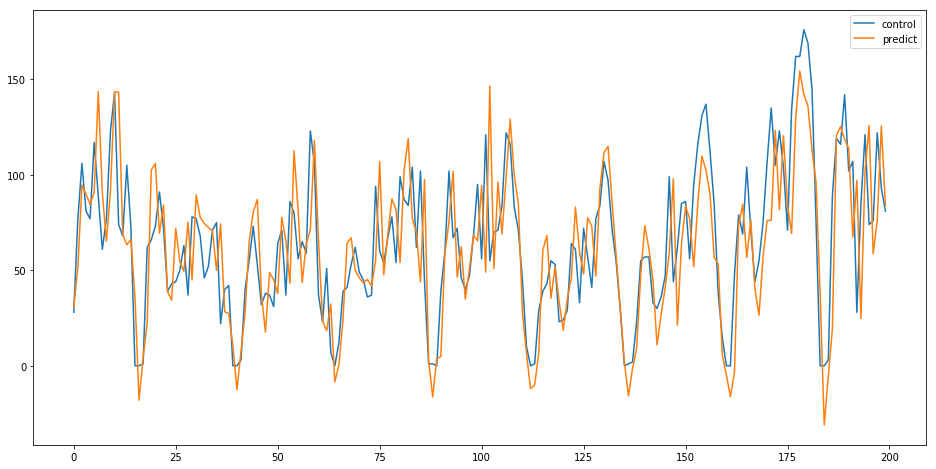

In [11]:
plt.figure(figsize=(16,8))
plt.plot(y_control[0].values[-200:], label='control')
plt.plot(model.predict(X_control)[-200:], label='predict')
plt.legend()
print(model.score(X_control, y_control[0]))
print(metrics.mean_absolute_error(y_control[0], model.predict(X_control)))

Линейные модели достаточно хорошо описывают данные, но далее мы попробуем случайный лес.

### Random Forest

Сформируем выборки, но сначала только с категориальными признаками:

In [12]:
times = data.index
us_holidays = holidays.US()
samples = []
for region in tqdm_notebook(list_region):
    sample = pd.DataFrame(index=times)
    sample['holiday'] = list(map(lambda x: x in us_holidays,times))
    sample['region'] = region
    sample['year'] = times.year
    sample['month'] = times.month
    sample['weekday'] = times.weekday
    sample['hour'] = times.hour
    for i in range(1,7):
        sample[f'target_{i}'] = data.loc[:,region].shift(-i).values
    samples.append(sample.dropna())
samples = pd.concat(samples)

In [13]:
y_train = []
y_control = []
y_test = []
X_train = samples.iloc[:,:-6][:'2016.04.30 17:00']
X_control = samples.iloc[:,:-6]['2016.04.30 23:00':'2016.05.31 17:00']
X_test = samples.iloc[:,:-6]['2016.05.31 23:00':'2016.06.30 17:00']

for i in range(-6,0):
    y_train.append(samples.iloc[:,i][:'2016.04.30 17:00'])
    y_control.append(samples.iloc[:,i]['2016.04.30 23:00':'2016.05.31 17:00'])
    y_test.append(samples.iloc[:,i]['2016.05.31 23:00':'2016.06.30 17:00'])

In [14]:
rf = ensemble.RandomForestRegressor(n_estimators=30, max_features=1/3,
                                    random_state=1, n_jobs=-1).fit(X_train,y_train[0])
predict_rf = rf.predict(X_control)

0.9695672503377782
19.020101836091815


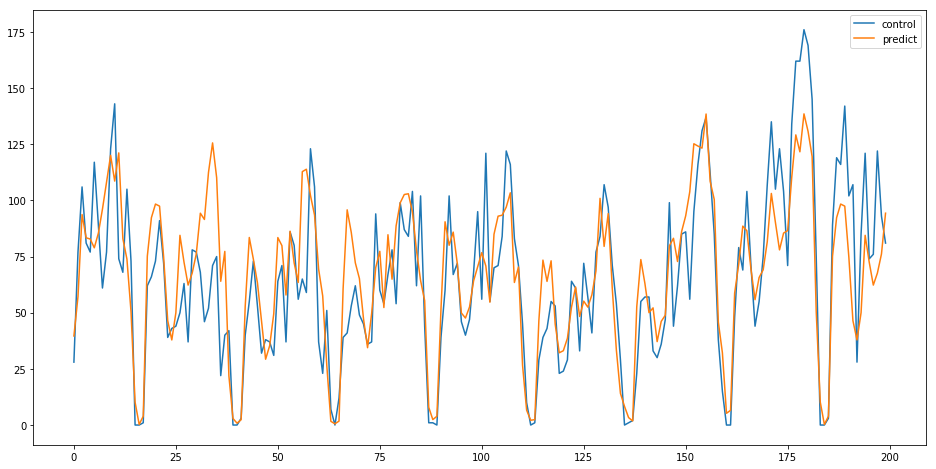

In [16]:
plt.figure(figsize=(16,8))
plt.plot(y_control[0].values[-200:], label='control')
plt.plot(rf.predict(X_control)[-200:], label='predict')
plt.legend()
print(rf.score(X_control,y_control[0]))
print(metrics.mean_absolute_error(y_control[0], rf.predict(X_control)))

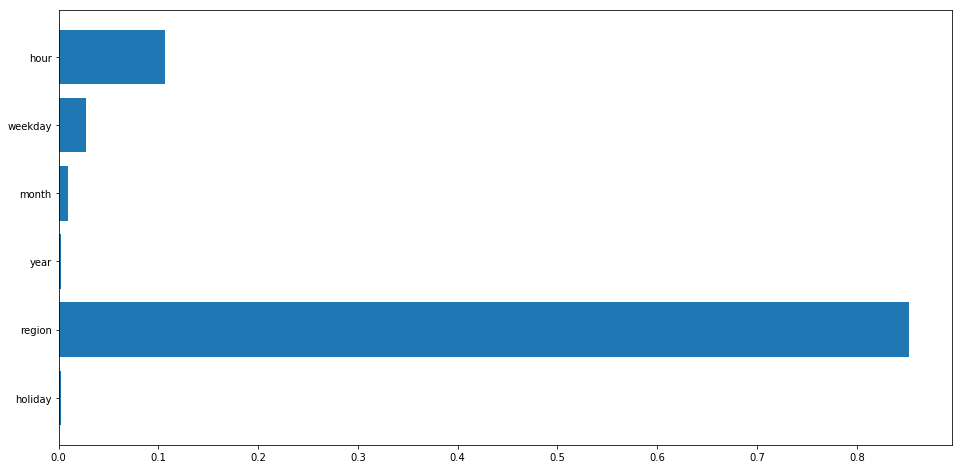

In [17]:
plt.figure(figsize=(16,8))
plt.barh(X_train.columns, rf.feature_importances_, align='center',log=False)
plt.show()

Удивительно, но 4 признака описывают данные лучше, чем 200 признаков и линейная регрессия. 

Добавим числовые данные:

In [ ]:
times = data.index
us_holidays = holidays.US()
K = 24 # количество поездок за К часов
K_d = 7 # количество поездок за К*24 часа
samples = []
for region in tqdm_notebook(list_region):
    sample = pd.DataFrame(index=times)
    sample['holiday'] = list(map(lambda x: x in us_holidays,times))
    sample['region'] = region
    sample['year'] = times.year
    sample['month'] = times.month
    sample['weekday'] = times.weekday
    sample['hour'] = times.hour
    for i in range(K):
        sample[f'{i}_hours_ago'] = data.loc[:,region].shift(i).values
    for i in range(1, K_d+1):
        sample[f'{i*24}_hours_ago'] = data.loc[:,region].shift(i*24).values
    sample['total_trips_half-day'] = data.loc[:,region].rolling(12).sum().values
    sample['total_trips_day'] = data.loc[:,region].rolling(24).sum().values
    sample['total_trips_week'] = data.loc[:,region].rolling(168).sum().values
    for i in range(1,7):
        sample[f'target_{i}'] = data.loc[:,region].shift(-i).values
    samples.append(sample.dropna())
samples = pd.concat(samples)

In [ ]:
y_train = []
y_control = []
y_test = []
X_train = samples.iloc[:,:-6][:'2016.04.30 17:00']
X_control = samples.iloc[:,:-6]['2016.04.30 23:00':'2016.05.31 17:00']
X_test = samples.iloc[:,:-6]['2016.05.31 23:00':'2016.06.30 17:00']

for i in range(-6,0):
    y_train.append(samples.iloc[:,i][:'2016.04.30 17:00'])
    y_control.append(samples.iloc[:,i]['2016.04.30 23:00':'2016.05.31 17:00'])
    y_test.append(samples.iloc[:,i]['2016.05.31 23:00':'2016.06.30 17:00'])

In [58]:
rf = ensemble.RandomForestRegressor(n_estimators=30, max_features=1/3,
                                    random_state=1, n_jobs=-1).fit(X_train,y_train[0])

0.9864975909965832
14.502862462080005


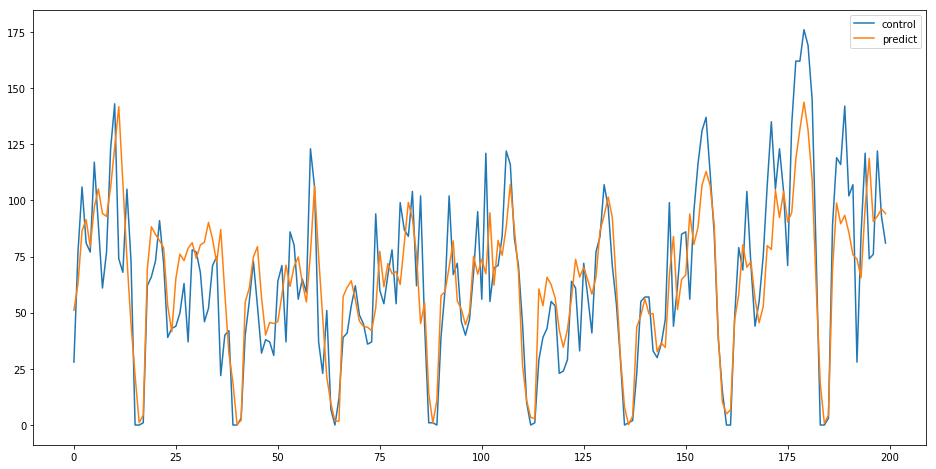

In [22]:
plt.figure(figsize=(16,8))
plt.plot(y_control[0].values[-200:], label='control')
plt.plot(rf.predict(X_control)[-200:], label='predict')
plt.legend()
print(rf.score(X_control,y_control[0]))
print(metrics.mean_absolute_error(y_control[0], rf.predict(X_control)))

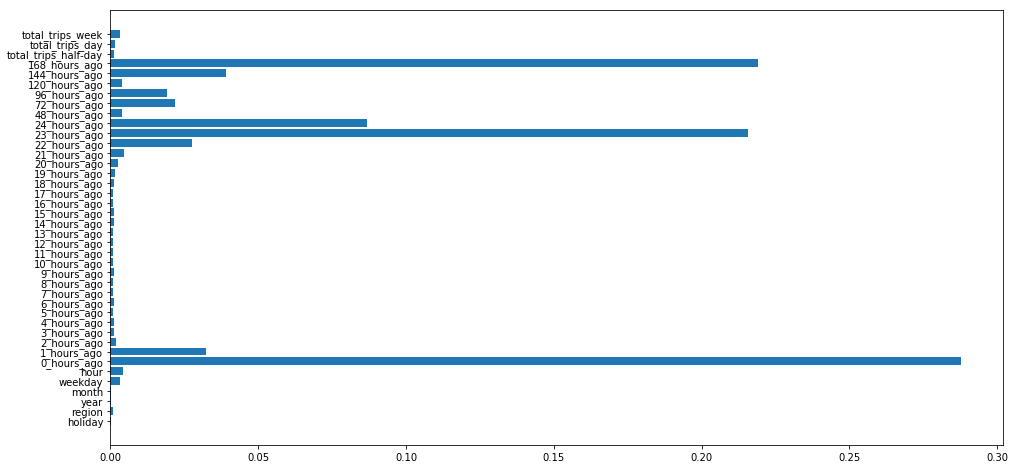

In [23]:
plt.figure(figsize=(16,8))
plt.barh(X_train.columns, rf.feature_importances_, align='center',log=False)
plt.show()

Качество также улучшилось. Случайный лес показал результат лучше, чем линейная регрессия - далее будем настраивать именно его.

### Подбор гиперпараметров

Теперь попробуем улучшить наш результат подбором следующих гиперпараметров:
- Число признаков для выбора расщепления — max_features

При увеличении max_features увеличивается время построения леса, а деревья становятся «более однообразными». По умолчанию он равен sqrt(n) в задачах классификации и n/3 в задачах регрессии.

- Число деревьев — n_estimators

Чем больше деревьев, тем лучше качество, но время настройки и работы RF также пропорционально увеличиваются. Поэтому постараемся найти значение, когда качество на тесте выходит на асимптоту.

#### max_features

In [44]:
Q_train = []
Q_control = []
max_features  = range(1,len(X_train.columns),5)
for n in tqdm_notebook(max_features):
    model = ensemble.RandomForestRegressor(n_estimators=32,max_features = n,n_jobs=-1).fit(X_train.values,y_train[0].values)
    Q_train.append(metrics.mean_absolute_error(y_train[0], model.predict(X_train)))
    Q_control.append(metrics.mean_absolute_error(y_control[0], model.predict(X_control)))

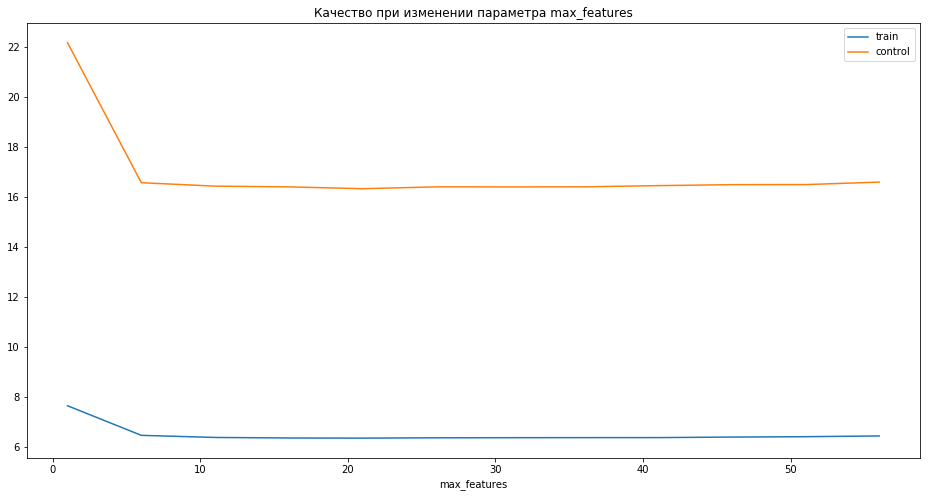

In [52]:
plt.figure(figsize=(16,8))
plt.plot(max_features, Q_train,label='train')
plt.plot(max_features, Q_control,label='control')
plt.xlabel('MAE')
plt.xlabel('max_features')
plt.title('Качество при изменении параметра max_features')
plt.legend()
plt.show()

Качество перестает изменяться примерно с 10 признаков, посмотрии поближе:

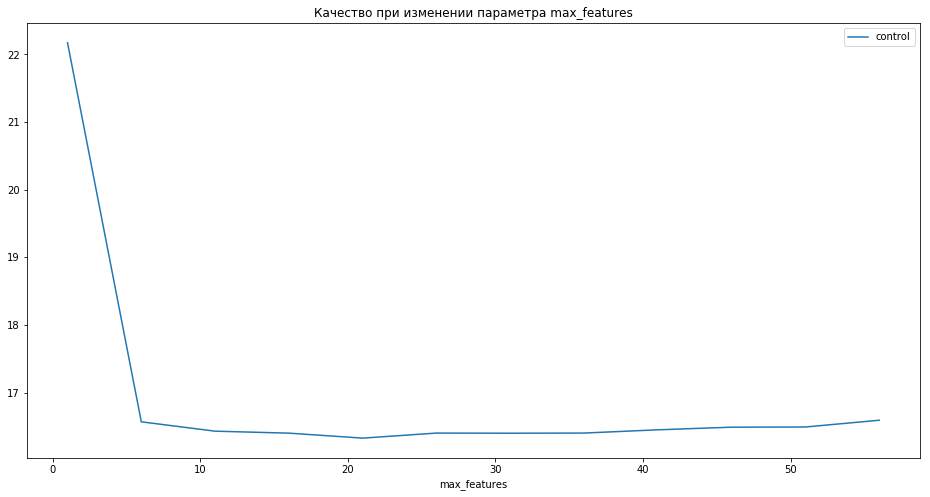

In [53]:
plt.figure(figsize=(16,8))
plt.plot(max_features, Q_control,label='control')
plt.xlabel('MAE')
plt.xlabel('max_features')
plt.title('Качество при изменении параметра max_features')
plt.legend()
plt.show()

Минимум примерно на 20, как и в рекомендациях n/3. Примем это значение для дальнейшего обучения

#### n_estimators

In [54]:
Q_train = []
Q_control = []
n_estimators  = range(10,100,5)
for n in tqdm_notebook(n_estimators):
    model = ensemble.RandomForestRegressor(max_features=10, n_estimators=n,n_jobs=-1).fit(X_train.values,y_train[0].values)
    Q_train.append(metrics.mean_absolute_error(y_train[0], model.predict(X_train)))
    Q_control.append(metrics.mean_absolute_error(y_control[0], model.predict(X_control)))

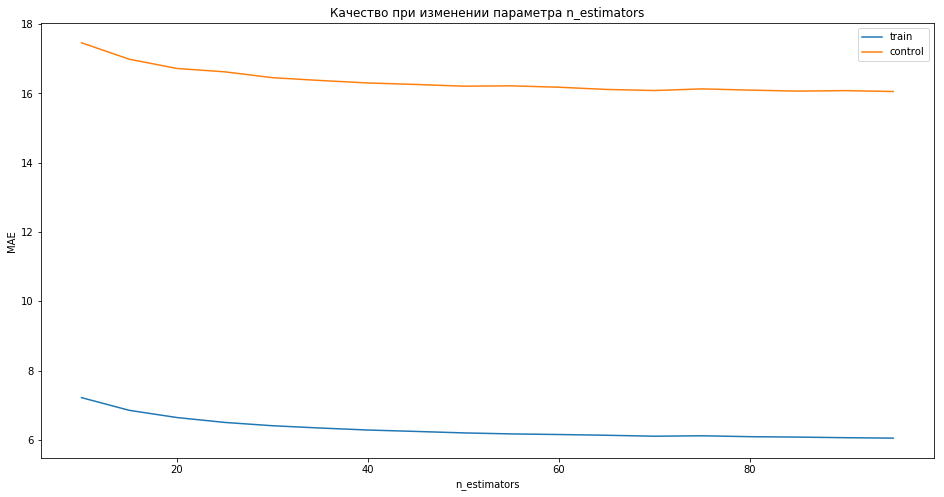

In [60]:
plt.figure(figsize=(16,8))
plt.plot(n_estimators, Q_train,label='train')
plt.plot(n_estimators, Q_control,label='control')
plt.ylabel('MAE')
plt.xlabel('n_estimators')
plt.title('Качество при изменении параметра n_estimators')
plt.legend()
plt.show()

Возможно надо было взять больший диапазон

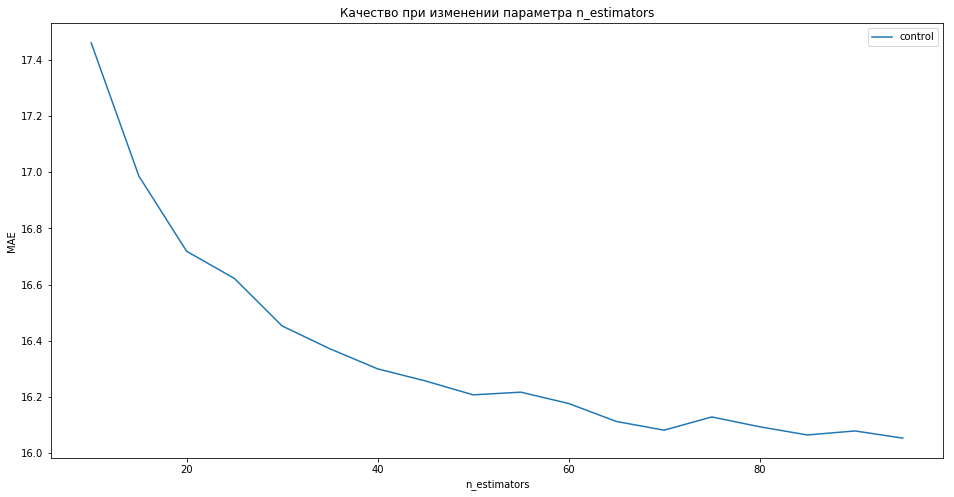

In [61]:
plt.figure(figsize=(16,8))
plt.plot(n_estimators, Q_control,label='control')
plt.ylabel('MAE')
plt.xlabel('n_estimators')
plt.title('Качество при изменении параметра n_estimators')
plt.legend()
plt.show()

Но мы примем 70 деревьев)

### Обучение моделей и оценка качества на данных мая

In [16]:
models = []
Q_control = []
for i in tqdm_notebook(range(6)):
    models.append(ensemble.RandomForestRegressor(n_estimators=70, max_features=20,
                                                 n_jobs=-1).fit(X_train.values, y_train[i].values))
    Q_control.append(metrics.mean_absolute_error(y_control[i], models[i].predict(X_control)))
Q_control = sum(Q_control) / 6
print(f'Ошибка прогноза: {Q_control:.1f}')


Ошибка прогноза: 17.5


В моем случае качество на порядок лучше, чем с ARIMAой

### Прогноз на июнь

Возможно стоило обучиться заново с включением майских данных, но качество и так было хорошее

In [18]:
predict = []
predict_kaggle = []
regions = X_test.region.values
for i in range(6):
    predict = models[i].predict(X_test)
    for j,t in enumerate(X_test.index):
        region = regions[j]
        idx = '_'.join([str(int(region)),str(t.date()),str(t.hour),str(i+1)])
        y = str((predict[j]))
        answer = ','.join([idx, y])
        predict_kaggle.append(answer)
print('\n'.join(predict_kaggle[:10]))

1075_2016-05-31_23_1,30.37142857142857
1075_2016-06-01_0_1,13.685714285714285
1075_2016-06-01_1_1,7.542857142857143
1075_2016-06-01_2_1,4.385714285714286
1075_2016-06-01_3_1,5.114285714285714
1075_2016-06-01_4_1,8.128571428571428
1075_2016-06-01_5_1,21.385714285714286
1075_2016-06-01_6_1,47.51428571428571
1075_2016-06-01_7_1,83.12857142857143
1075_2016-06-01_8_1,60.7


In [19]:
with open('results.csv','w') as f:
    f.write('id,y\n')
    f.write('\n'.join(predict_kaggle))

На kaggle получилось score = 16.75535

Спасибо за просмотр)